## Setting Up the Libs and Marmousi2 Configurations

In [27]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import random
torch.manual_seed(0)
random.seed(0)

####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 5.                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = 30.0                  # step interval along x/z direction
dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 117                   # model shape of z dimension (depth) Marmousi2
ny        = 567                   # model shape of y dimension Marmousi2
vmodel_dim = np.array([nz, ny])

total_t   = 6.                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
num_shots = 30                      # nunmber of shots
num_sources_per_shot = 1            # number of sources per shot
num_receivers_per_shot = 567        # number of receivers per shot
source_spacing = np.floor(dx * ny / (num_shots+1))                         # space intervel between neigbouring sources
receiver_spacing = np.floor(dx * ny / (num_receivers_per_shot +1))         # space intervel between neigbouring receivers
source_depth = 0                # the index depth of sources, default is 0
receiver_depth = 0              # the index depths of receivers, default is 0
order          = 8              # precision order of finite difference in space domain
pml_width  = [0,10,10,10,0,0]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

fwi_lr            = 20        # learning rate for updating the model.
fwi_batch         =   30      # number of batches for FWI.
fwi_num_epochs    = 800       # number of FWI iteration.
sim_lr            = 1*1e-4    # learning rate for Soamese network.
survey_pad = None
savepoch = 50                 # Saving models each 50 FWI iterations


##   Check Cuda Device 


In [29]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
device

device(type='cuda')

## Creating Data Pathes

In [23]:
 
data_path = 'data/mar_big_117_567.bin'
initfile = 'data/mar_big_initmodel.mat'
initsafile = 'data/mar_big_initsource.mat'
fwi_result = 'results/Marmousi2/'
# Loading the true model
model_true = loadtruemodel(data_path, num_dims, vmodel_dim).to(device)
model, model_init = loadinitmodel(initfile,device)
# The model will be updated during FWI
model = torch.nn.Parameter(model)
# Creating source and reciver locations
x_s, x_r = createSR(num_shots, num_sources_per_shot, num_receivers_per_shot, num_dims, source_spacing, receiver_spacing,source_depth,receiver_depth)
x_s, x_r = x_s.to(device), x_r.to(device)
# Source Amplitude
source_amplitudes_init, source_amplitudes_true = loadinitsource(initsafile,device)
source = source_amplitudes_init.repeat(1,num_shots, num_sources_per_shot)
# receiver Amplitude
receiver_amplitudes = createdata(model_true,dx,source, \
                                x_s,x_r,dt,pml_width,order, \
                                 survey_pad,device).to(device)
receiver_amplitudes_true = receiver_amplitudes
rcv_amps_true = receiver_amplitudes_true.clone()

In [24]:
#rcv_amps_true = rcv_amps_true.detach().cpu().numpy()
#np.save('rcv_amps_true',rcv_amps_true)
rcv_amps_true.shape

torch.Size([2000, 30, 567])

## Plotting the inital and true model


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


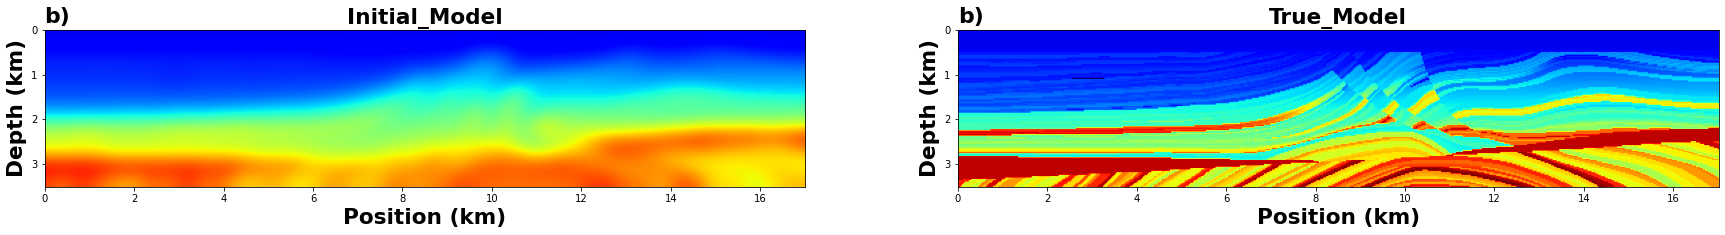

In [4]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3, 4])
box_min = 1140
box_max = 4700

f, ax = plt.subplots(1,2,figsize=(30, 13))
plt.rc('font', **font)


im = ax[0].imshow(model_init, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model_init.shape[1] * dx / 1000, model_init.shape[0] * dx / 1000, 0])
ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'b)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

model1 = model_true.detach().cpu().numpy()
im = ax[1].imshow(model1, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model1.shape[1] * dx / 1000, model1.shape[0] * dx / 1000, 0])
ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('True_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 


plt.show()

## Setting Up the Siamese and Optimizers

In [5]:
from torchsummary import summary
from Model.Module22 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 1/2


### optimizer for the velocity model
optimizer = optim.Adam([{'params': model, 'lr':fwi_lr, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.99), \
                    eps=1e-6, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

summary(netD,[(1,nt,num_receivers_per_shot),(1,nt,num_receivers_per_shot)])


############## Init  ################# 
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0




Number of netD params: 565
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1, 2000, 567]              10
         LeakyReLU-2         [-1, 1, 2000, 567]               0
            Conv2d-3         [-1, 2, 2000, 567]              20
         LeakyReLU-4         [-1, 2, 2000, 567]               0
            Conv2d-5         [-1, 2, 2000, 567]              20
         LeakyReLU-6         [-1, 2, 2000, 567]               0
            Conv2d-7         [-1, 4, 2000, 567]              40
         LeakyReLU-8         [-1, 4, 2000, 567]               0
            Conv2d-9         [-1, 4, 2000, 567]              40
        LeakyReLU-10         [-1, 4, 2000, 567]               0
           Conv2d-11         [-1, 2, 2000, 567]              20
        LeakyReLU-12         [-1, 2, 2000, 567]               0
           Conv2d-13         [-1, 1, 2000, 567]              10
        Leak

In [6]:
def Xcorr(x,y):
    x = x/torch.norm(x)
    y = y/torch.norm(y)
    loss = -torch.sum(torch.mul(x,y))
    return loss

## Main SiameseFWI

In [7]:
 
import torch.nn.functional as F
# Starting the FWI loop.
global model_true, source_amplitudes_init, SNR, SSIM, Loss, ERROR






t_start = time.time()
model_true = model_true.view(nz,ny)
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
criterion = nn.MSELoss()
for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizers to zero grad.
        optimizer.zero_grad()
        netD.train()                
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
                                          order,survey_pad)
        batch_src_amps = source_amplitudes_init.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true[:,it::fwi_batch].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)

        # Prepare the data for Siamese network.
        d_real = batch_rcv_amps_true.permute(1,0,2)
        d_real = d_real.unsqueeze(1)
        # train with fake data
        d_fake = batch_rcv_amps_pred.permute(1,0,2)
        d_fake = d_fake.unsqueeze(1)
        disc_fake, disc_real, o1, o2 = netD(d_fake,d_real)
        # Measure the Eculedian Loss.
        loss =   F.pairwise_distance(o1, o2, keepdim = True).mean()
        #loss = Xcorr(o1, o2)
        
        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        optim_s.step()
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model,1e3) 
        # Update the velocity model
        optimizer.step()
        # clip the model value that keep the minimum value is larger than 0
        model.data=torch.clamp(model.data,min=1e-12)


    # Update the learning rate each 100 FWI iterations .
    #if (i>0) and (i%100==0):
    #    scheduler.step()
    after_lr = optim_s.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    snr = ComputeSNR(model.detach().cpu().numpy(),  
              model_true.detach().cpu().numpy())
    SNR = np.append(SNR, snr)

    ssim = ComputeSSIM(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    SSIM = np.append(SSIM, ssim)

    rerror = ComputeRE(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    ERROR = np.append(ERROR, rerror)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr:' , str(after_lr), 'SNR:', snr, 'SSIM:', ssim.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'SIAMESERec_.mat', \
                         {'rec':model.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESEMetric_.mat', \
                         {'SNR':SNR,'SSIM':SSIM, \
                          'Loss':Loss,'ERROR':ERROR}) 

# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snr,ssim,rerror)), fmt='%5.4f') 



Epoch: 1 Loss:  0.5902204861243566 lr: 0.0001 SNR: 18.01929000278216 SSIM: 0.34623876
Epoch: 2 Loss:  0.45557541052500405 lr: 0.0001 SNR: 18.330145140775326 SSIM: 0.43264654
Epoch: 3 Loss:  0.4209561000267665 lr: 0.0001 SNR: 18.482598531097597 SSIM: 0.4694421
Epoch: 4 Loss:  0.4077684094508489 lr: 0.0001 SNR: 18.620691770664813 SSIM: 0.49425483
Epoch: 5 Loss:  0.3675849532087644 lr: 0.0001 SNR: 18.705391705882533 SSIM: 0.5151115
Epoch: 6 Loss:  0.3215589498480161 lr: 0.0001 SNR: 18.73649279437068 SSIM: 0.5316462
Epoch: 7 Loss:  0.28524627337853115 lr: 0.0001 SNR: 18.802690696840582 SSIM: 0.5416409
Epoch: 8 Loss:  0.23675172080596288 lr: 0.0001 SNR: 18.91732267157891 SSIM: 0.55633706
Epoch: 9 Loss:  0.17393116702636083 lr: 0.0001 SNR: 19.037124347214593 SSIM: 0.56714326
Epoch: 10 Loss:  0.10827610914905866 lr: 0.0001 SNR: 19.127762398641654 SSIM: 0.5777742
Epoch: 11 Loss:  0.08712790620823702 lr: 0.0001 SNR: 19.18992214559337 SSIM: 0.5877845
Epoch: 12 Loss:  0.08752287849783898 lr: 0.00

Epoch: 94 Loss:  0.004166581660198668 lr: 0.0001 SNR: 21.10956809146593 SSIM: 0.6467604
Epoch: 95 Loss:  0.004040078974018494 lr: 0.0001 SNR: 21.116519924918506 SSIM: 0.64749134
Epoch: 96 Loss:  0.0038265929790213702 lr: 0.0001 SNR: 21.11997614027777 SSIM: 0.64896
Epoch: 97 Loss:  0.0034926680304730932 lr: 0.0001 SNR: 21.1288712589186 SSIM: 0.6499805
Epoch: 98 Loss:  0.0033450774072359005 lr: 0.0001 SNR: 21.131972917431252 SSIM: 0.65124226
Epoch: 99 Loss:  0.0031895683069402972 lr: 0.0001 SNR: 21.136729300395718 SSIM: 0.6511081
Epoch: 100 Loss:  0.002996213990263641 lr: 0.0001 SNR: 21.142696003910597 SSIM: 0.65387577
Epoch: 101 Loss:  0.002771963004488498 lr: 0.0001 SNR: 21.148901863410046 SSIM: 0.65469897
Epoch: 102 Loss:  0.0026175450805264217 lr: 0.0001 SNR: 21.15404632399919 SSIM: 0.6571644
Epoch: 103 Loss:  0.002413339400663972 lr: 0.0001 SNR: 21.159397391802905 SSIM: 0.6579898
Epoch: 104 Loss:  0.002211381681263447 lr: 0.0001 SNR: 21.16531353996217 SSIM: 0.66089964
Epoch: 105 Los

Epoch: 185 Loss:  0.0006113285664469004 lr: 0.0001 SNR: 21.46040342991838 SSIM: 0.70767176
Epoch: 186 Loss:  0.0006155139242764562 lr: 0.0001 SNR: 21.463509104125265 SSIM: 0.7075481
Epoch: 187 Loss:  0.0006059472138683001 lr: 0.0001 SNR: 21.46450639343915 SSIM: 0.7080533
Epoch: 188 Loss:  0.0006139069174726804 lr: 0.0001 SNR: 21.467379264040225 SSIM: 0.70771897
Epoch: 189 Loss:  0.0006240383459953591 lr: 0.0001 SNR: 21.467914568714544 SSIM: 0.70804644
Epoch: 190 Loss:  0.0006119137697775538 lr: 0.0001 SNR: 21.471230204951645 SSIM: 0.7078585
Epoch: 191 Loss:  0.0005919792796097075 lr: 0.0001 SNR: 21.47231806361598 SSIM: 0.70847124
Epoch: 192 Loss:  0.0005975469529706363 lr: 0.0001 SNR: 21.47509549129627 SSIM: 0.70832175
Epoch: 193 Loss:  0.000606743111469162 lr: 0.0001 SNR: 21.47608175844811 SSIM: 0.7086508
Epoch: 194 Loss:  0.0005996774076872194 lr: 0.0001 SNR: 21.478917476548702 SSIM: 0.70841557
Epoch: 195 Loss:  0.0005825795902637765 lr: 0.0001 SNR: 21.47995247837345 SSIM: 0.7092658


Epoch: 276 Loss:  0.00045564472287272414 lr: 0.0001 SNR: 21.612672830528506 SSIM: 0.719795
Epoch: 277 Loss:  0.0004791569556497658 lr: 0.0001 SNR: 21.612713793654436 SSIM: 0.7195749
Epoch: 278 Loss:  0.0004879884882636058 lr: 0.0001 SNR: 21.61527073880127 SSIM: 0.7191057
Epoch: 279 Loss:  0.0005033584874278555 lr: 0.0001 SNR: 21.61538067724312 SSIM: 0.7192155
Epoch: 280 Loss:  0.00047116100613493473 lr: 0.0001 SNR: 21.617743589052033 SSIM: 0.7193379
Epoch: 281 Loss:  0.00045931824812820804 lr: 0.0001 SNR: 21.618134346721114 SSIM: 0.71976656
Epoch: 282 Loss:  0.0004746958724960374 lr: 0.0001 SNR: 21.620643624972146 SSIM: 0.71918976
Epoch: 283 Loss:  0.0004959301926040401 lr: 0.0001 SNR: 21.62049293182779 SSIM: 0.7194432
Epoch: 284 Loss:  0.0004873792534150804 lr: 0.0001 SNR: 21.623003111195736 SSIM: 0.71899974
Epoch: 285 Loss:  0.00047616363735869527 lr: 0.0001 SNR: 21.623710827955858 SSIM: 0.7197092
Epoch: 286 Loss:  0.0004485907067040292 lr: 0.0001 SNR: 21.625964674744402 SSIM: 0.7200

Epoch: 366 Loss:  0.0004876318596264658 lr: 0.0001 SNR: 21.722793161150115 SSIM: 0.7244068
Epoch: 367 Loss:  0.0003499985818052664 lr: 0.0001 SNR: 21.724532609356988 SSIM: 0.7273943
Epoch: 368 Loss:  0.0003342784882988781 lr: 0.0001 SNR: 21.726659851996754 SSIM: 0.7289355
Epoch: 369 Loss:  0.00036398311688875157 lr: 0.0001 SNR: 21.727372298691098 SSIM: 0.7290906
Epoch: 370 Loss:  0.00036055118350001675 lr: 0.0001 SNR: 21.72957538726039 SSIM: 0.72869664
Epoch: 371 Loss:  0.00036621346371248367 lr: 0.0001 SNR: 21.730180051622362 SSIM: 0.72791547
Epoch: 372 Loss:  0.00041732559766387566 lr: 0.0001 SNR: 21.73144332802556 SSIM: 0.72604454
Epoch: 373 Loss:  0.00040557892692352955 lr: 0.0001 SNR: 21.732062636977297 SSIM: 0.727816
Epoch: 374 Loss:  0.0004274421211448498 lr: 0.0001 SNR: 21.733044088226556 SSIM: 0.72719514
Epoch: 375 Loss:  0.00038176766004956636 lr: 0.0001 SNR: 21.734562787927835 SSIM: 0.7283416
Epoch: 376 Loss:  0.00035447640790759274 lr: 0.0001 SNR: 21.73573037198023 SSIM: 0.

Epoch: 456 Loss:  0.0003099210996879265 lr: 0.0001 SNR: 21.81685878156177 SSIM: 0.73473275
Epoch: 457 Loss:  0.0002646321440503622 lr: 0.0001 SNR: 21.818066057041744 SSIM: 0.7359979
Epoch: 458 Loss:  0.0002976554659350465 lr: 0.0001 SNR: 21.81979130117901 SSIM: 0.73550826
Epoch: 459 Loss:  0.0003231082577258348 lr: 0.0001 SNR: 21.819710259485188 SSIM: 0.7349309
Epoch: 460 Loss:  0.0003494189455523156 lr: 0.0001 SNR: 21.821095390938893 SSIM: 0.7346706
Epoch: 461 Loss:  0.0006312900072468135 lr: 0.0001 SNR: 21.81922414027894 SSIM: 0.7271803
Epoch: 462 Loss:  0.00032748022737602394 lr: 0.0001 SNR: 21.823289480896705 SSIM: 0.73537904
Epoch: 463 Loss:  0.0002555132756242529 lr: 0.0001 SNR: 21.824486000980123 SSIM: 0.737291
Epoch: 464 Loss:  0.0002907715340067322 lr: 0.0001 SNR: 21.82625254604064 SSIM: 0.73767495
Epoch: 465 Loss:  0.00032967578057044495 lr: 0.0001 SNR: 21.826361137130586 SSIM: 0.73555154
Epoch: 466 Loss:  0.0005335938326121929 lr: 0.0001 SNR: 21.82471626918465 SSIM: 0.730674

Epoch: 546 Loss:  0.0002325026332982816 lr: 0.0001 SNR: 21.892952803248164 SSIM: 0.74090856
Epoch: 547 Loss:  0.00024570974686260647 lr: 0.0001 SNR: 21.89457343128471 SSIM: 0.74175787
Epoch: 548 Loss:  0.0002579249907284975 lr: 0.0001 SNR: 21.895169655116383 SSIM: 0.7408423
Epoch: 549 Loss:  0.000266309101425577 lr: 0.0001 SNR: 21.896275153741783 SSIM: 0.74147296
Epoch: 550 Loss:  0.0006379250194489335 lr: 0.0001 SNR: 21.89204789432687 SSIM: 0.73213035
Epoch: 551 Loss:  0.0006243530015732783 lr: 0.0001 SNR: 21.892559824533798 SSIM: 0.73224944
Epoch: 552 Loss:  0.0003041857644954386 lr: 0.0001 SNR: 21.896894793791372 SSIM: 0.73723483
Epoch: 553 Loss:  0.00024350786067467805 lr: 0.0001 SNR: 21.897837661023797 SSIM: 0.74052465
Epoch: 554 Loss:  0.00025921391885882865 lr: 0.0001 SNR: 21.899386772502027 SSIM: 0.74113
Epoch: 555 Loss:  0.00026340428933811685 lr: 0.0001 SNR: 21.90020965750073 SSIM: 0.74120873
Epoch: 556 Loss:  0.0002732760006135019 lr: 0.0001 SNR: 21.901330310311437 SSIM: 0.7

Epoch: 636 Loss:  0.0002442370367740902 lr: 0.0001 SNR: 21.959380104597727 SSIM: 0.7438392
Epoch: 637 Loss:  0.0002814353176897081 lr: 0.0001 SNR: 21.959397928685163 SSIM: 0.7431358
Epoch: 638 Loss:  0.0002525965571597529 lr: 0.0001 SNR: 21.960855603401768 SSIM: 0.7435717
Epoch: 639 Loss:  0.00026042550501491254 lr: 0.0001 SNR: 21.961050753569047 SSIM: 0.7439563
Epoch: 640 Loss:  0.0003005909854740215 lr: 0.0001 SNR: 21.962382083381186 SSIM: 0.7421128
Epoch: 641 Loss:  0.00026152806143121176 lr: 0.0001 SNR: 21.962751146871177 SSIM: 0.7434407
Epoch: 642 Loss:  0.00039039316373722007 lr: 0.0001 SNR: 21.962941467830625 SSIM: 0.74069387
Epoch: 643 Loss:  0.0003127533015989078 lr: 0.0001 SNR: 21.964277568533387 SSIM: 0.74257576
Epoch: 644 Loss:  0.0002471492278952307 lr: 0.0001 SNR: 21.96584918558241 SSIM: 0.7447448
Epoch: 645 Loss:  0.0002246032808519279 lr: 0.0001 SNR: 21.966860977148194 SSIM: 0.74466896
Epoch: 646 Loss:  0.0002328844988369383 lr: 0.0001 SNR: 21.967646472691804 SSIM: 0.74

Epoch: 726 Loss:  0.00023700606252532452 lr: 0.0001 SNR: 22.01834390222452 SSIM: 0.74736017
Epoch: 727 Loss:  0.0006301198600946616 lr: 0.0001 SNR: 22.011958782845124 SSIM: 0.73631287
Epoch: 728 Loss:  0.0003586267742017905 lr: 0.0001 SNR: 22.018404687301047 SSIM: 0.74363065
Epoch: 729 Loss:  0.00018665893124610497 lr: 0.0001 SNR: 22.019782966427126 SSIM: 0.74818027
Epoch: 730 Loss:  0.00019265941809862853 lr: 0.0001 SNR: 22.021115570134068 SSIM: 0.7484123
Epoch: 731 Loss:  0.00020646047487389297 lr: 0.0001 SNR: 22.02185751053047 SSIM: 0.7476111
Epoch: 732 Loss:  0.0002326152127352543 lr: 0.0001 SNR: 22.02231359841313 SSIM: 0.74640864
Epoch: 733 Loss:  0.00022543578622086596 lr: 0.0001 SNR: 22.02341777557805 SSIM: 0.74767834
Epoch: 734 Loss:  0.00026458684345319247 lr: 0.0001 SNR: 22.02354206218758 SSIM: 0.744916
Epoch: 735 Loss:  0.00023186085503160332 lr: 0.0001 SNR: 22.024818619169192 SSIM: 0.7468353
Epoch: 736 Loss:  0.0002668689519244557 lr: 0.0001 SNR: 22.024199170107597 SSIM: 0.

## Plotting the Reconstructed Velocity Model

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


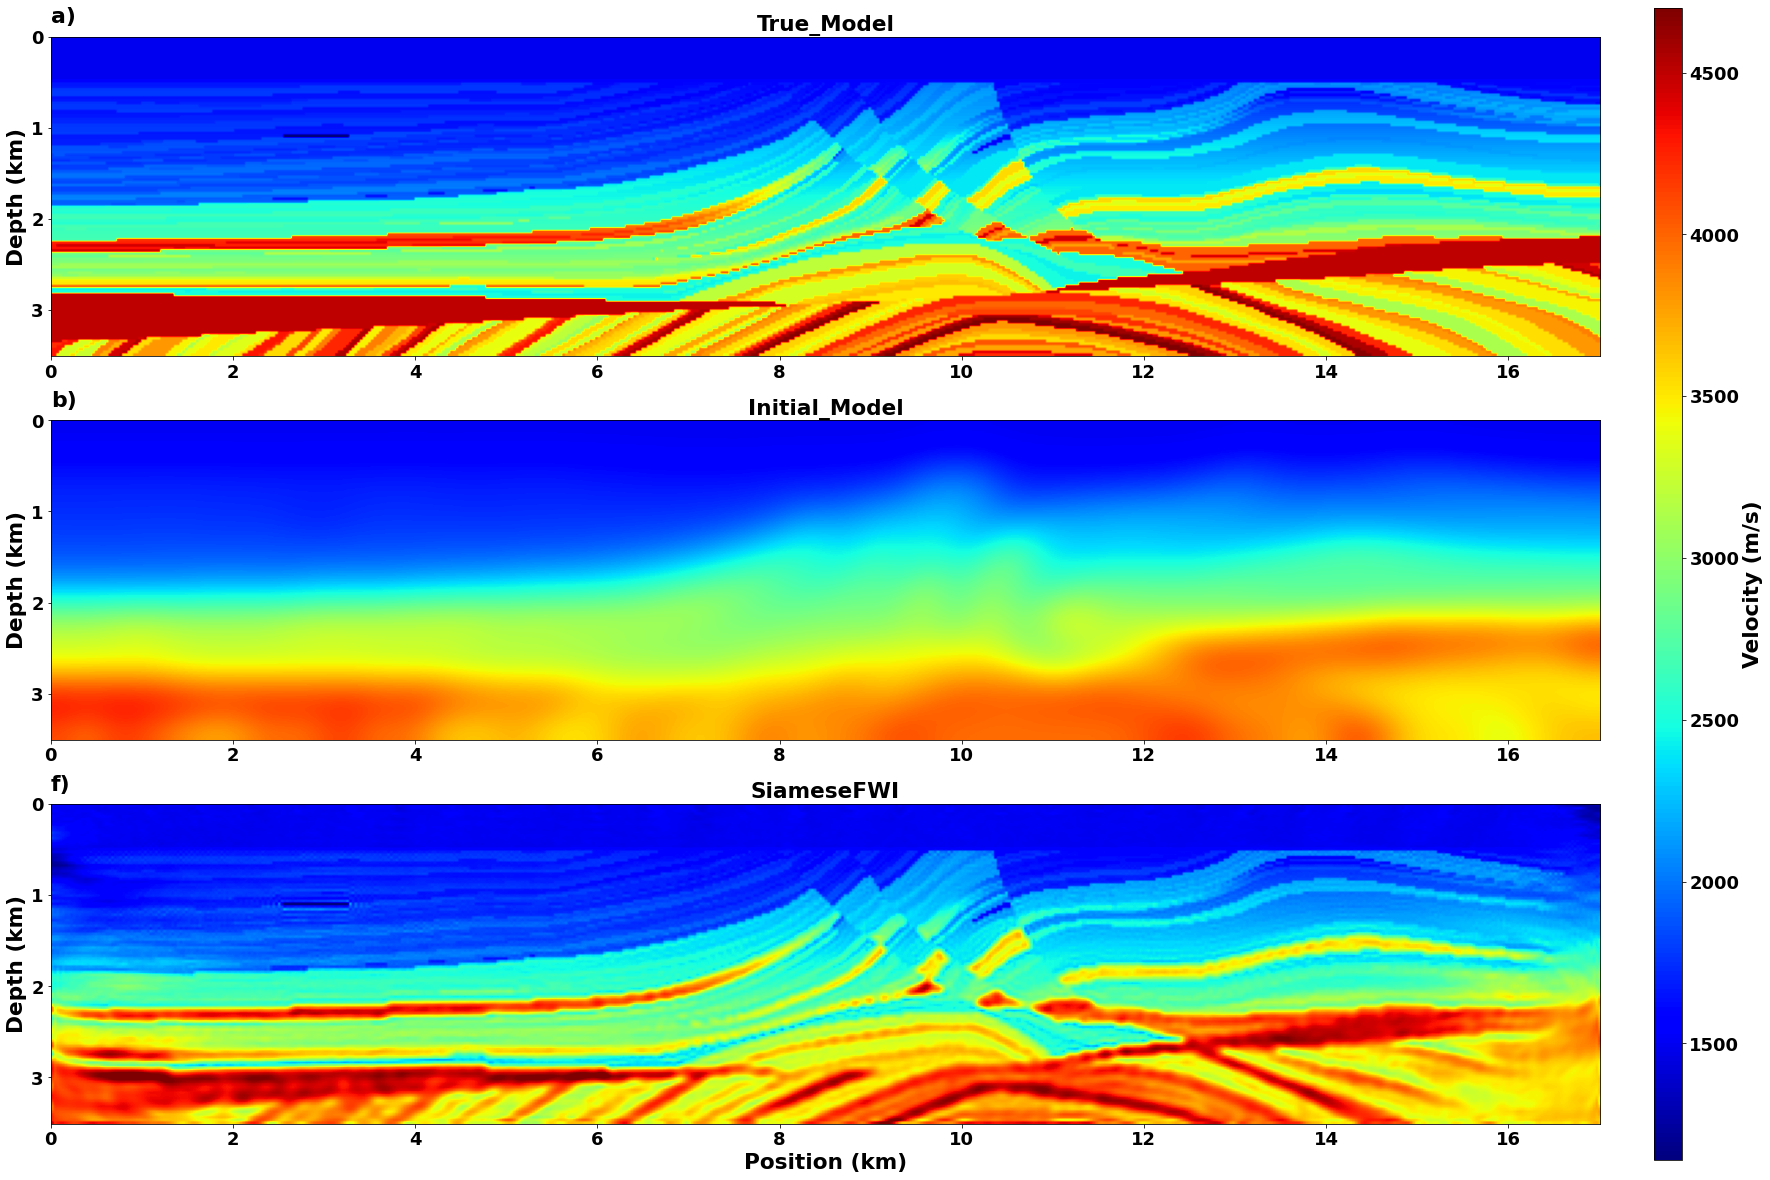

The reconstructed velocity model has SNR: 22.06119565801208 dB and SSIM: 0.7458525


In [8]:
f, ax = plt.subplots(3,1,figsize=(40, 20))
plt.rc('font', **font)

# True Model
modeltrue = model1
im = ax[0].imshow(modeltrue, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modeltrue.shape[1] * dx / 1000, modeltrue.shape[0] * dx / 1000, 0])

#ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('True_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'a)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Initial Model
init_V = model_init
im = ax[1].imshow(init_V, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, init_V.shape[1] * dx / 1000, init_V.shape[0] * dx / 1000, 0])
#ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Siamese Model
Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERec_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2].imshow(Siamese_Vel, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, Siamese_Vel.shape[1] * dx / 1000, Siamese_Vel.shape[0] * dx / 1000, 0])
ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2].set_title('SiameseFWI',fontsize='large', fontweight='bold')
ax[2].text(0, -0.15, 'f)', fontsize = 22) 
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].set_yticks(np.arange(y.min(), y.max(), 1)) 


cbar_ax = f.add_axes([0.8, 0.1, 0.01, 0.8])
f.colorbar(im, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

plt.show()

snr = ComputeSNR(Siamese_Vel,  
          model_true.detach().cpu().numpy())

ssim = ComputeSSIM(Siamese_Vel, \
          model_true.detach().cpu().numpy())

print('The reconstructed velocity model has SNR:', str(snr), 'dB', 'and SSIM:',str(ssim.cpu().detach().cpu().numpy()))

## Plotting Velocities Profiles

@Position =  3.6 km, RMSE =  0.21255357992450333 km/s
@Position =  7.2 km, RMSE =  0.18547971413461692 km/s
@Position =  14.4 km, RMSE =  0.1549183786645004 km/s


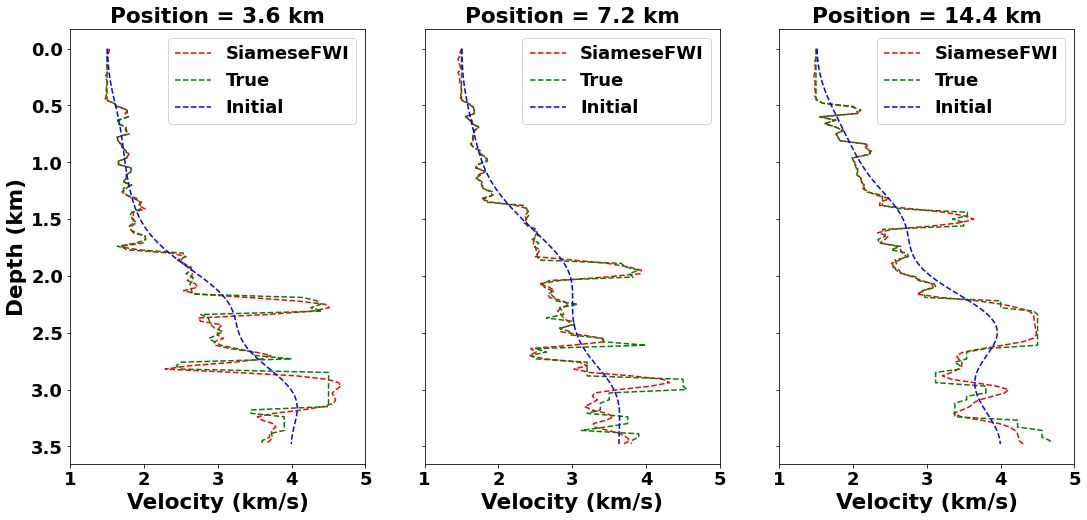

In [9]:
from math import sqrt

# position 1
k = 120

xy = np.arange(0,Siamese_Vel.shape[0] * dx / 1000, len(Siamese_Vel[:,k])/Siamese_Vel.shape[0] * dx / 1000)
f, ax = plt.subplots(figsize=(18, 8), ncols=3,nrows=1)
xx = np.arange(0,4)
ax[0].plot(Siamese_Vel[:,k]/1000,xy,'r--',label='SiameseFWI')
ax[0].plot(modeltrue[:,k]/1000,xy,'g--',label='True')
ax[0].plot(init_V[:,k]/1000,xy,'b--',label='Initial')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_xlabel('Velocity (km/s)',fontsize='large', fontweight='bold')
ax[0].set_xlim([1,5])
ax[0].legend(loc='upper right')
ax[0].set_title( 'Position = ' + str(k * dx / 1000) +' km',fontsize='large', fontweight='bold')
ax[0].invert_yaxis()
rms = sqrt(np.mean(((modeltrue[:,k]-Siamese_Vel[:,k])/1000)**2))
print('@Position = ', str(k * dx / 1000), 'km, RMSE = ',str(rms), 'km/s')

# position 2
k = 240
xy = np.arange(0,Siamese_Vel.shape[0] * dx / 1000, len(Siamese_Vel[:,k])/Siamese_Vel.shape[0] * dx / 1000)
xx = np.arange(0,4)
ax[1].plot(Siamese_Vel[:,k]/1000,xy,'r--',label='SiameseFWI')
ax[1].plot(modeltrue[:,k]/1000,xy,'g--',label='True')
ax[1].plot(init_V[:,k]/1000,xy,'b--',label='Initial')
ax[1].set_xlabel('Velocity (km/s)',fontsize='large', fontweight='bold')
ax[1].set_yticklabels([])
ax[1].set_xlim([1,5])
ax[1].legend(loc='upper right')
ax[1].set_title( 'Position = ' + str(k * dx / 1000) +' km',fontsize='large', fontweight='bold')
ax[1].invert_yaxis()
rms = sqrt(np.mean(((modeltrue[:,k]-Siamese_Vel[:,k])/1000)**2))
print('@Position = ', str(k * dx / 1000), 'km, RMSE = ',str(rms), 'km/s')

# position 3
k = 480
xy = np.arange(0,Siamese_Vel.shape[0] * dx / 1000, len(Siamese_Vel[:,k])/Siamese_Vel.shape[0] * dx / 1000)
xx = np.arange(0,4)
ax[2].plot(Siamese_Vel[:,k]/1000,xy,'r--',label='SiameseFWI')
ax[2].plot(modeltrue[:,k]/1000,xy,'g--',label='True')
#ax[2].plot(FWIGAN_Vel[:,k]/1000,xy,'y--',label='FWIGAN')
ax[2].plot(init_V[:,k]/1000,xy,'b--',label='Initial')
ax[2].set_xlabel('Velocity (km/s)',fontsize='large', fontweight='bold')
ax[2].set_yticklabels([])
ax[2].set_xlim([1,5])
#ax[2].ylim([0,3.8])
ax[2].legend(loc='upper right')
ax[2].set_title( 'Position = ' + str(k * dx / 1000) +' km',fontsize='large', fontweight='bold')
ax[2].invert_yaxis()
rms = sqrt(np.mean(((modeltrue[:,k]-Siamese_Vel[:,k])/1000)**2))
print('@Position = ', str(k * dx / 1000), 'km, RMSE = ',str(rms), 'km/s')



In [10]:
#torch.save(netD.state_dict(), fwi_result + 'netD')
#netD = torch.load(fwi_result + 'netD')
#netD